In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.environ['CONFIG_DIR'] = "/content/gdrive/My Drive/Project"
%cd /content/gdrive/My Drive/Project
%ls

#!pip install -U tensorflow==2.0.0-alpha0

# Import needed packages

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from os import listdir
from os.path import isfile, join
import pandas as pd
from sklearn.model_selection import train_test_split
import gc; gc.enable() # memory is tight

from keras import layers, models
from keras import backend as K
from keras.optimizers import Adam

Using TensorFlow backend.


In [ ]:

train_image_dir_l = 'kitti/training/label_2/'

train_image_dir = 'kitti/training/image_2/'

images =  [(train_image_dir+f) for f in listdir(train_image_dir) if isfile(join(train_image_dir, f))]
masks = [(train_image_dir_l+f) for f in listdir(train_image_dir_l) if isfile(join(train_image_dir_l, f))]

df = pd.DataFrame(np.column_stack([images, masks]), columns=['images', 'masks'])


In [ ]:
df1 = df.sort_values(by='images')['images'].reset_index()
# df1 = df.sort_values(by='a')['a']
df2 = df.sort_values(by='masks')['masks'].reset_index()
# df2 = df.sort_values(by='b')['b']
df['images'] = df1['images']
df['masks'] = df2['masks']
del df1, df2

In [ ]:
df

,images,masks
0,../input/kitti_single/training/image_2/000000.png,../input/kitti_single/training/label_2/000000.txt
1,../input/kitti_single/training/image_2/000001.png,../input/kitti_single/training/label_2/000001.txt
2,../input/kitti_single/training/image_2/000002.png,../input/kitti_single/training/label_2/000002.txt
3,../input/kitti_single/training/image_2/000003.png,../input/kitti_single/training/label_2/000003.txt
4,../input/kitti_single/training/image_2/000004.png,../input/kitti_single/training/label_2/000004.txt
5,../input/kitti_single/training/image_2/000005.png,../input/kitti_single/training/label_2/000005.txt
6,../input/kitti_single/training/image_2/000006.png,../input/kitti_single/training/label_2/000006.txt
7,../input/kitti_single/training/image_2/000007.png,../input/kitti_single/training/label_2/000007.txt
8,../input/kitti_single/training/image_2/000008.png,../input/kitti_single/training/label_2/000008.txt
9,../input/kitti_single/training/image_2/000009.png,../input/kitti_single/training/label_2/000009.txt


In [ ]:
def create_mask(mask_dir, img_shape):
    mask = np.zeros(shape=(img_shape[0], img_shape[1], 1))

    with open(mask_dir) as f:
        content = f.readlines()
    content = [x.split() for x in content] 
    for item in content:
        if item[0]=='Car':
            ul_col, ul_row = int(float(item[4])), int(float(item[5]))
            lr_col, lr_row = int(float(item[6])), int(float(item[7]))
            
            mask[ul_row:lr_row, ul_col:lr_col, 0] = 1 
    return mask

In [ ]:
df_train, df_val = train_test_split(df, test_size=0.25, shuffle=False)
# In[]
'''Constants
'''
BATCH_SIZE = 64
EDGE_CROP = 16
NB_EPOCHS = 30
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [ ]:

# In[]
'''make batchs of images
'''
def create_images_generator(df_in, batch_size, resized_shape):
    batch_image = []
    batch_mask = []
    df_in_list = (df_in).values.tolist()

    np.random.shuffle(df_in_list)
    #return df_in_list    
    
    while True:
#         np.random.shuffle(df_in_list)
        for image_path, mask_path in df_in_list:
            image_r = cv2.imread(image_path)
            mask_r = create_mask(mask_path, image_r.shape)
            
            image_r = cv2.resize(image_r,(resized_shape[1], resized_shape[0]))
            mask_r = cv2.resize(mask_r,(resized_shape[1], resized_shape[0]))
            
            
            
            batch_image.append(image_r)
            batch_mask.append(mask_r)
            
            if len(batch_mask)>=batch_size:
                yield np.float32(np.stack((batch_image), 0)/255.0), np.stack(np.uint8(np.expand_dims(batch_mask, -1)), 0)
                batch_image, batch_mask = [], []



[[[0.9843137  0.7019608  0.44705883]
  [0.99607843 0.69411767 0.4392157 ]
  [1.         0.6901961  0.44705883]
  ...
  [0.8666667  0.5882353  0.36862746]
  [0.8901961  0.5882353  0.36862746]
  [0.8862745  0.58431375 0.37254903]]

 [[0.99215686 0.7058824  0.4509804 ]
  [1.         0.69803923 0.43137255]
  [0.99607843 0.7137255  0.46666667]
  ...
  [0.8627451  0.5921569  0.36862746]
  [0.8784314  0.5921569  0.3647059 ]
  [0.8745098  0.6        0.3529412 ]]

 [[1.         0.7137255  0.45490196]
  [0.9882353  0.7137255  0.4627451 ]
  [1.         0.7058824  0.4627451 ]
  ...
  [0.8901961  0.59607846 0.37254903]
  [0.8745098  0.6039216  0.36862746]
  [0.8784314  0.58431375 0.36862746]]

 ...

 [[0.36078432 0.34117648 0.31764707]
  [0.3529412  0.3529412  0.37254903]
  [0.37254903 0.34901962 0.35686275]
  ...
  [0.42352942 0.43137255 0.44313726]
  [0.44705883 0.42745098 0.43529412]
  [0.40784314 0.4392157  0.4745098 ]]

 [[0.34117648 0.3529412  0.34117648]
  [0.4        0.38039216 0.3764706 ]


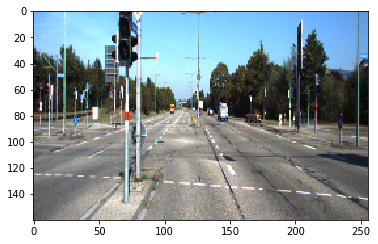

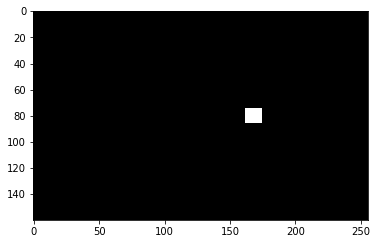

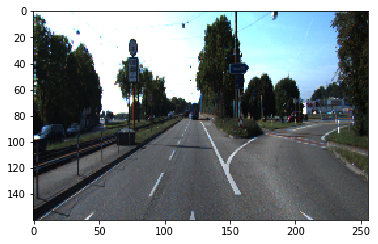

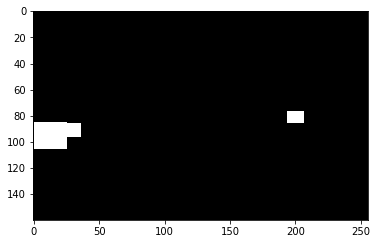

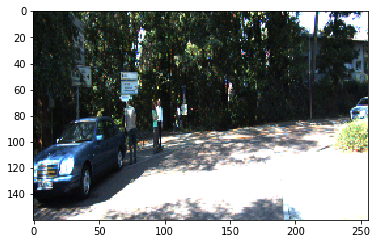

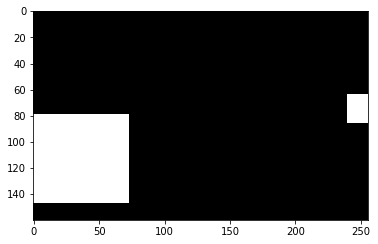

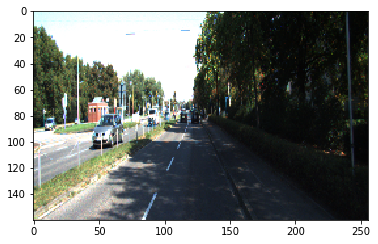

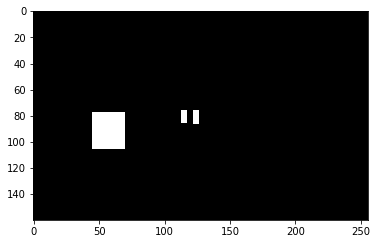

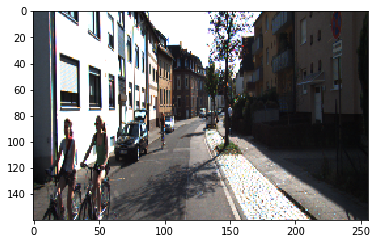

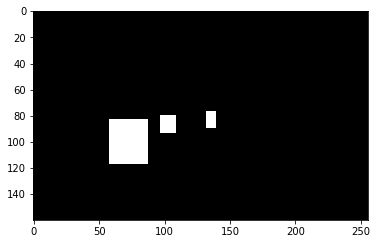

In [ ]:
resized_shape = (160, 256)                
train_gen = create_images_generator(df_train, batch_size=BATCH_SIZE, resized_shape=resized_shape)
#print(train_gen)
batch_img, batch_mask = next(train_gen)
print(batch_img[0], batch_mask[0])
for i in range(5):

    im = np.array(255*batch_img[i],dtype=np.uint8)
    im_mask = np.array(batch_mask[i],dtype=np.uint8)
    
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.figure()
    plt.imshow(im_mask[:,:,0], cmap= 'gray')
    plt.show()


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
args_dg = dict(featurewise_center = False, 
               samplewise_center = False, 
               rotation_range = 2, 
               width_shift_range = 0.1, 
               shear_range = 0.01,
               zoom_range = [0.9, 1.1], 
               horizontal_flip = False, 
               vertical_flip = False,
               fill_mode = 'constant',
               data_format = 'channels_last')

if AUGMENT_BRIGHTNESS:
    args_dg['brightness_range'] = [0.5, 1.5]

image_gen = ImageDataGenerator(**args_dg)

if AUGMENT_BRIGHTNESS:
    args_dg.pop('brightness_range')
mask_gen = ImageDataGenerator(**args_dg)

print(image_gen)

In [ ]:
# In[]
def make_augment_generator(img_mask_gen, seed=None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    
    for img_in, mask_in in img_mask_gen:
        seed = np.random.choice(range(9999))
        aug_img_in = image_gen.flow(255*img_in, 
                                 batch_size=img_in.shape[0],
                                 seed = seed, 
                                 shuffle=True)
        aug_mask_in = mask_gen.flow(mask_in, 
                                    batch_size=img_in.shape[0],
                                    seed=seed,
                                    shuffle=True)
        yield next(aug_img_in)/255.0, next(aug_mask_in)

In [ ]:

def calc_IOU(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f*y_pred_f)
    
    return (2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
def calc_IOU_loss(y_true, y_pred):
    return -calc_IOU(y_true, y_pred)

# In[]
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)

def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
def create_unet():
    
    # input_img = layers.Input(batch_img.shape[1:], name = 'RGB_Input')
    input_img = layers.Input((resized_shape[0],resized_shape[1],3), name = 'RGB_Input')
    pp_in_layer = input_img
             
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(pp_in_layer)
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2)) (c3)
    
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)
    
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
    
    
    u6 = upsample(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = upsample(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = upsample(16, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c9)
    
    d = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    # d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
    # d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
    if NET_SCALING is not None:
        d = layers.UpSampling2D(NET_SCALING)(d)
    
    seg_model = models.Model(inputs=[input_img], outputs=[d])
    seg_model.summary()
    
    return seg_model

In [ ]:

# In[]
model = create_unet()
model.compile(optimizer=Adam(lr=1e-4),
              loss=calc_IOU_loss, metrics=[calc_IOU])
# In[]
#history = model.fit(train_gen,samples_per_epoch=40,nb_epoch=2)    

train_gen = create_images_generator(df_train, batch_size=BATCH_SIZE, resized_shape=resized_shape)
valid_gen = create_images_generator(df_train, batch_size=BATCH_SIZE, resized_shape=resized_shape)

# aug_gen = make_augment_generator(train_gen)

val_img, val_mask = next(valid_gen)  

loss_history = [model.fit_generator(train_gen,
 steps_per_epoch=20,
 epochs=200,
 validation_data=(val_img, val_mask) )]



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          (None, 160, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 256, 8)  224         RGB_Input[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 160, 256, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 80, 128, 8)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [ ]:
 model_json = model.to_json()
with open("model_car.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model_car.h5")
print("Saved model to disk")

Saved model to disk


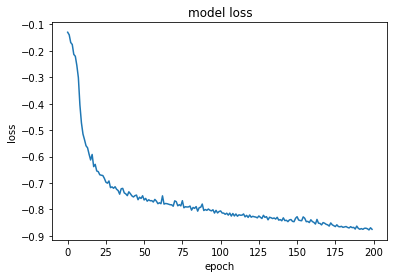

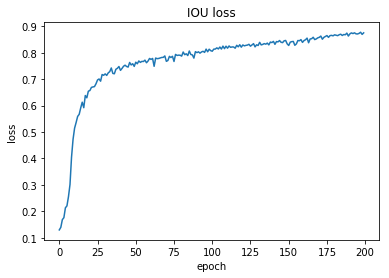

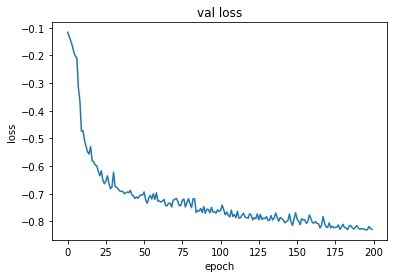

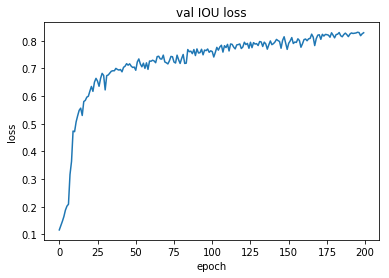

In [ ]:
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(loss_history[0].history['loss'])
plt.show()
plt.title('IOU loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(loss_history[0].history['calc_IOU'])
plt.show()
plt.title('val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(loss_history[0].history['val_loss'])
plt.show()
plt.title('val IOU loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(loss_history[0].history['val_calc_IOU'])
plt.show()


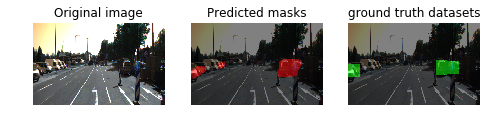

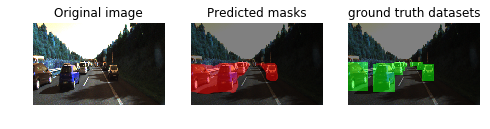

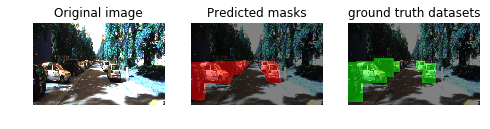

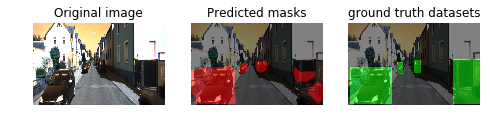

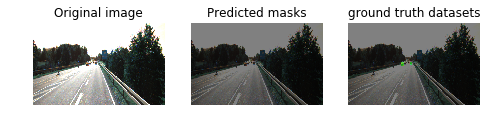

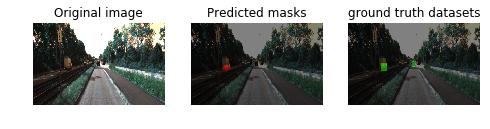

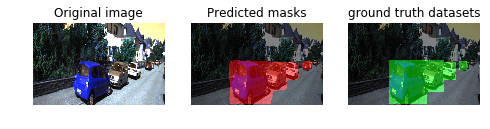

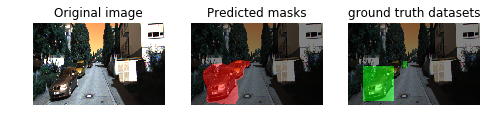

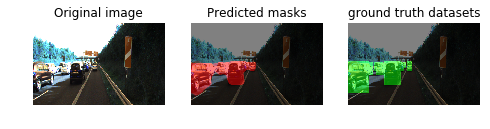

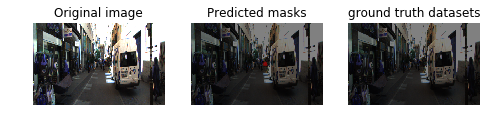

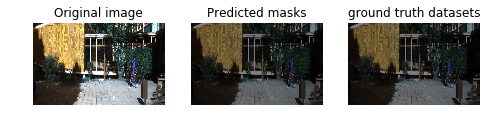

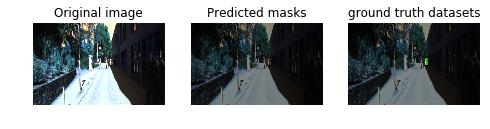

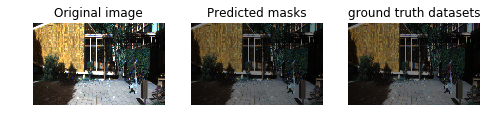

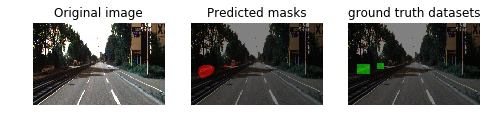

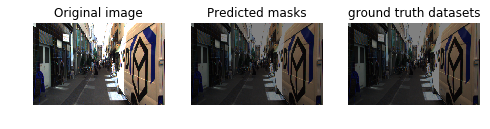

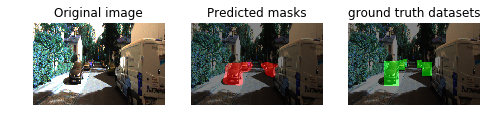

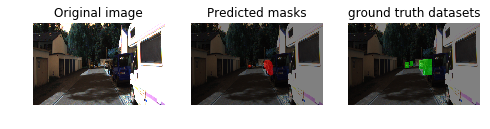

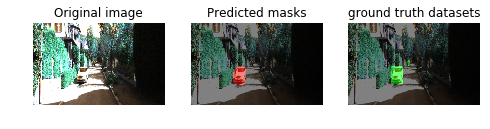

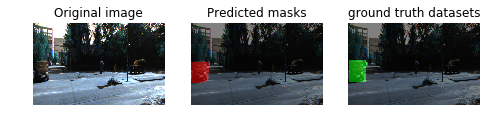

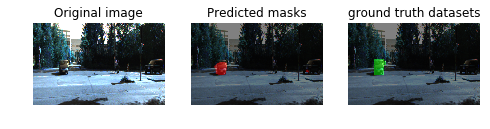

In [ ]:

pred_all= model.predict(val_img)
np.shape(pred_all)

for i in range(20):

    im = np.array(255*val_img[i],dtype=np.uint8)
    im_mask = np.array(255*val_mask[i],dtype=np.uint8)
    im_pred = np.array(255*pred_all[i],dtype=np.uint8)
    #im_pred1 = np.array(255*pred_all[i],dtype=np.uint8)
    
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    #rgb_mask_pred1 = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    temp1 = rgb_mask_pred[:,:,1:3]
    temp2 = rgb_mask_pred[:,:,1:2]
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:3]
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]

    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)

    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title('Predicted masks')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(img_true)
    plt.title('ground truth datasets')
    plt.axis('off')
    plt.show()    


